# Stable Diffusion

In [1]:
!nvidia-smi

Tue Mar 19 14:35:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Instalação das bibliotecas

- [xformers](https://github.com/facebookresearch/xformers) para otimização da memória



In [2]:
!pip install -q torch torchvision torchaudio torchdata torchtext --upgrade
!pip install -q diffusers --upgrade
!pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

## Pipeline para geração da imagem

Podemos definir com pouco esforço um pipeline para utilizar o modelo do Stable Diffusion, através do [StableDiffusionPipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py)



  > **Pipeline** -  Um pipeline é uma classe end-to-end que fornece uma maneira rápida e fácil de usar um sistema de difusão para inferência agrupando modelos e schedulers treinados independentemente. Certas combinações de modelos e agendadores definem tipos de pipeline específicos, como `StableDiffusionPipeline` ou `StableDiffusionControlNetPipeline`, com recursos específicos. Todos os tipos de pipeline herdam da classe base `DiffusionPipeline`; basta passar o checkpoint e ele detectará automaticamente o tipo de pipeline e carregará os componentes necessários.

Utilizaremos a função `from_pretrained` para especificar de qual modelo queremos carregar os pesos. A função escrita para esse módulo diffusers está preparada para fazer o download automático do modelo.


3**Observação:** Se você estiver limitado pela memória da GPU e tiver menos de 10 GB de RAM da GPU disponível, certifique-se de carregar o StableDiffusionPipeline na precisão float16 em vez da precisão float32 padrão, conforme feito acima.

Como estamos usando a versão gratuita do Google Colab, não temos controle de qual GPU será atribuída. Como queremos garantir que todos possam executar o modelo, vamos especificar como parâmetro na função o `torch_dtype` com o valor `torch.float16`.
E para isso funcionar, estaremos carregando os pesos do branch de meia precisão (*half-precision branch*) fp16. Mais informações [aqui](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16)




In [105]:
import torch
from diffusers import StableDiffusionPipeline, AutoPipelineForText2Image
from diffusers import DPMSolverMultistepScheduler

#### referência de schedulers
https://huggingface.co/docs/diffusers/v0.26.2/en/api/schedulers/overview#schedulers

In [40]:
from PIL import Image

def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

### Modelo epiCRealism
* https://huggingface.co/emilianJR/epiCRealism

In [12]:
model_id = "emilianJR/epiCRealism"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to('cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### Definição do prompt

In [25]:
prompt = '(best quality, masterpiece, colorful, dynamic angle, highest detailed) Raspberry cake with white filling, chocolate chips, strawberries on top, two candles, powdered sugar, whipped cream'

###Prompt Negativo

In [26]:
negative_prompt = 'FastNegativeV2 (worst quality, low quality, normal quality, lowres, low details, oversaturated, undersaturated, overexposed, underexposed, greyscale, bw, bad photo, bad photography, bad art:1.4), (watermark, signature, autograph, trademark), (blur, blurry, grainy), morbid, ugly, mutated, malformed, asymmetrical, nonsymmetrical, mutilated, poorly lit, bad shadow, draft, cropped, out of frame, cut off, censored, jpeg artefacts, out of focus, glitch, duplicate, disembodied, floating objects,, (airbrushed, cartoon, anime, semi-realistic, cgi, render, blender, digital art, manga, sketch, amateur:1.3), (3D, 3D game, 3D game scene, 3D character:1.1), (bad hands, bad anatomy, bad body, bad face, bad teeth, bad arms, bad legs, bad feet, bad hands, deformities:1.3)'

### Geração da imagem



In [29]:
generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=4,
            num_inference_steps=30).images


  0%|          | 0/30 [00:00<?, ?it/s]

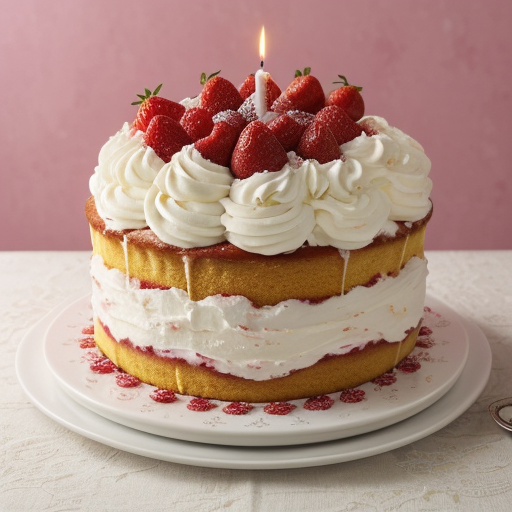

In [30]:
imgs[0]

In [70]:
prompt = [
    "a race car, background mechanic shop, dslr, ultra quality, Fujifilm XT3, 8K UHD, highly detailed",
    "1970 dodge charger gt, focus on car,8k resolution, photo realistic, 3d rendering",
    "a motocycle in a shop,cyberpunk style, edge light, well lit, bokeh"

]

neg_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo, people, text"
    ] * len(prompt)

In [71]:
generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = neg_prompt,
            guidance_scale=5,
            num_inference_steps=36).images

  0%|          | 0/36 [00:00<?, ?it/s]

<ipython-input-40-e1b143025a31>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


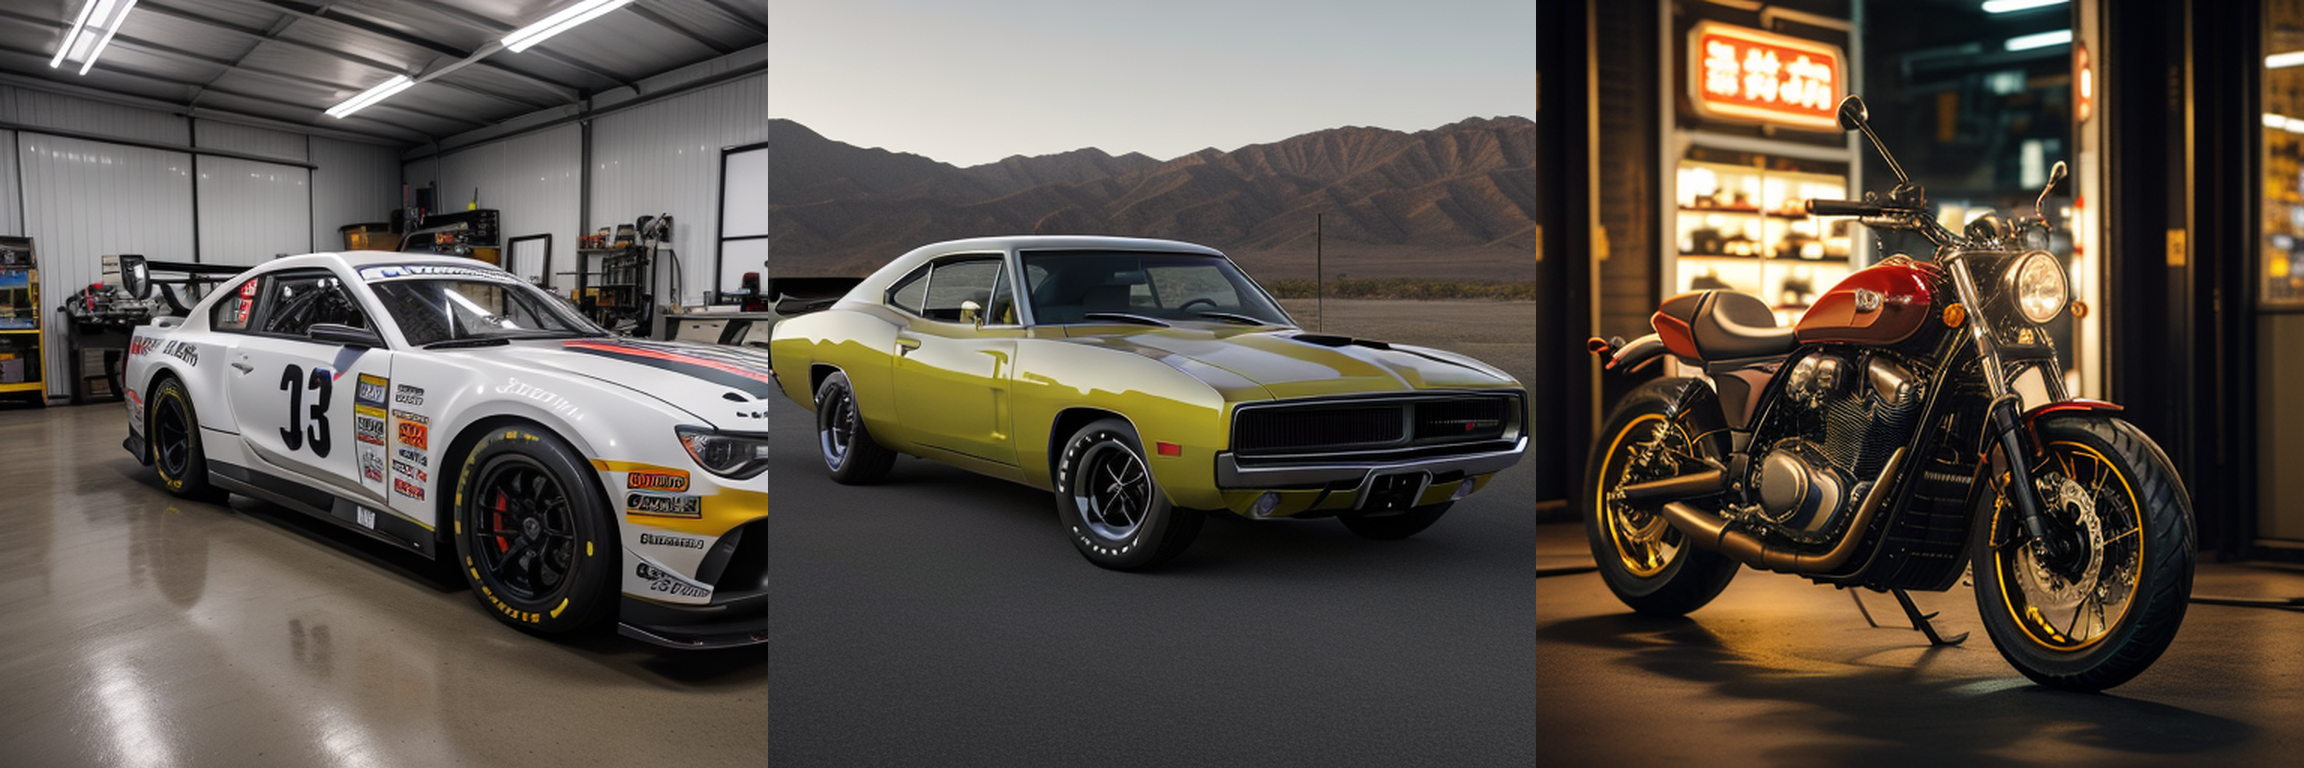

In [73]:
grid = grid_img(imgs, rows=1, cols=len(prompt), scale=1.5)
grid

### DreamShaper  (`Lykon/DreamShaper`)
- Um modelo "mix" que engloba vários estilos.
 * https://huggingface.co/Lykon/DreamShaper

In [106]:
pipe = AutoPipelineForText2Image.from_pretrained('lykon/dreamshaper-xl-v2-turbo', torch_dtype=torch.float16, variant="fp16")
pipe = pipe.to('cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

model_index.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [111]:
prompt = [
    "man working as a construction worker, best quality, ultra-detailed,  wide angle, cinematic light, sidelighting, ultra high res, best shadow, 4k",
]

neg_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo"
    ] * len(prompt)

num_imgs = 3

In [ ]:
generator = torch.Generator("cuda").manual_seed(1144556)
imgs = pipe(prompt,
            generator=generator,
            num_images_per_prompt=num_imgs,
            negative_prompt = neg_prompt,
            guidance_scale=6,
            num_inference_steps=10).images

In [ ]:
grid = grid_img(imgs, rows=1, cols=len(prompt), scale=1)
grid

## Gerando vários resultados

In [ ]:
prompt = [
    "security camera footage of a car parking, dslr, ultra quality, Fujifilm XT3, 8K UHD, highly detailed"
]

neg_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo"
    ] * len(prompt)

In [ ]:
generator = torch.Generator("cuda").manual_seed(1144556)
imgs = pipe(prompt,
            generator=generator,
            num_images_per_prompt=num_imgs,
            negative_prompt = neg_prompt,
            guidance_scale=6,
            num_inference_steps=10).images

In [ ]:
grid = grid_img(imgs, rows=1, cols=len(prompt), scale=1)
grid

### Guidance scale (CFG)


Escolha do melhor valor

* Valores entre 7 e 8.5 geralmente são boas escolhas para o Stable Diffusion. Por padrão, o valor é 7.5

* No geral, você vai querer manter o valor padrão ou algo próximo (5~9). Recomenda-se ficar longe de valores muito baixos ou altos, pois verá que eles retornarão imagens menos realistas

* Definir o valor correto depende dos resultados desejados e também da complexidade do prompt de texto. A decisão é sua, mas é sempre melhor experimentar diferentes escalas para ver se resultados mais criativos ou resultados estritamente aderentes ao prompt são melhores para o seu caso de uso.

Um exemplo de caso de uso: quando o CFG é maior, conceitos do prompt são mais visíveis nas imagens. Se você está tentando gerar uma imagem com mais detalhes minúsculos especificados no prompt, pode começar com uma escala de orientação maior, talvez entre 10 e 18. Mas isso vai depender muito do prompt, ou modelo, portanto não há uma regra geral nesse caso, se você quer o resultado mais próximo do esperado então aproveite para "brincar" testando outros valores.


### Tamanho da imagem (proporção e orientação)

Por padrão, esse modelo do Stable Diffusion irá produzir imagens de 512 × 512 pixels. Mas é muito fácil substituir o padrão usando os argumentos de altura e largura.

Caso deseje alterar o tamanhos das imagem, há algumas recomendações:

* certifique-se de que a altura e a largura sejam múltiplos de 8.
* menor que 512 irá resultar em imagens de qualidade inferior.
* ultrapassar 512 em ambas as direções repetirá as áreas da imagem (portanto, perde-se a "coerência global").
* a melhor maneira de criar imagens não quadradas é usar 512 em uma dimensão (altura ou largura) e um valor maior na outra.

> Modo paisagem


  0%|          | 0/50 [00:00<?, ?it/s]

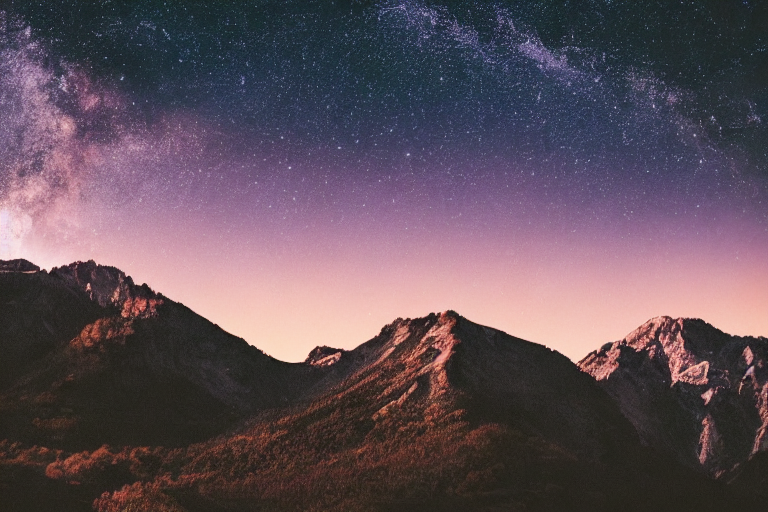

In [ ]:
seed = 777
prompt = "photograph of a mountain landscape during sunset, stars in the sky"
generator = torch.Generator("cuda").manual_seed(seed)

h, w = 512, 768

img = pipe(prompt, height=h, width=w, generator=generator).images[0]

img

> Modo retrato



  0%|          | 0/50 [00:00<?, ?it/s]

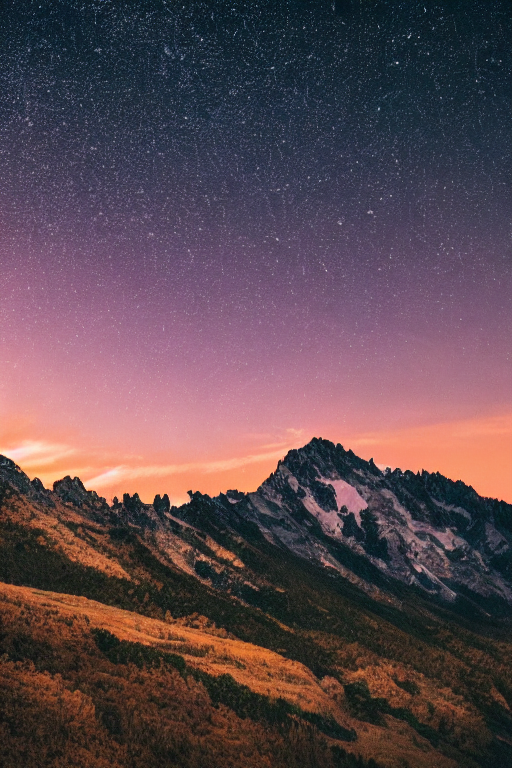

In [ ]:
generator = torch.Generator("cuda").manual_seed(seed)

h, w = 768, 512

img = pipe(prompt, height=h, width=w, generator=generator).images[0]

img

### Prompt negativo

### SD v2.x

In [ ]:
sd2 = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
sd2 = sd2.to("cuda")
sd2.enable_attention_slicing()
sd2.enable_xformers_memory_efficient_attention()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
pipe.scheduler.compatibles

[diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler]

In [ ]:
pipe.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('skip_prk_steps', True),
            ('set_alpha_to_one', False),
            ('prediction_type', 'epsilon'),
            ('steps_offset', 1),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.11.1'),
            ('clip_sample', False)])

In [ ]:
from diffusers import DDIMScheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

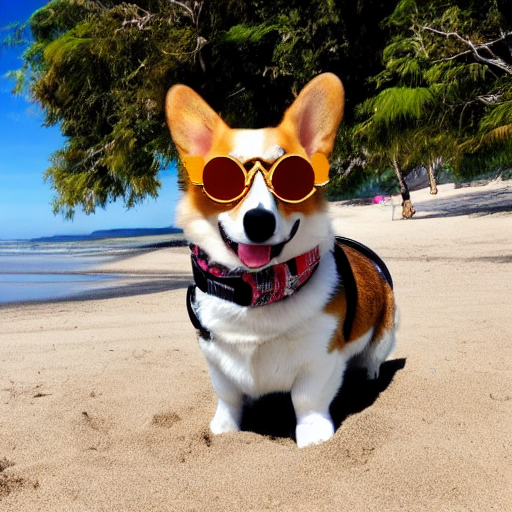

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seed)
img = pipe(prompt, generator=generator).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

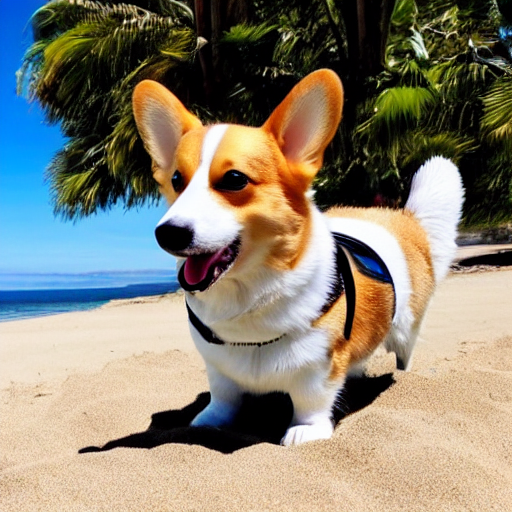

In [ ]:
from diffusers import LMSDiscreteScheduler

pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

generator = torch.Generator(device="cuda").manual_seed(seed)
img = pipe(prompt, generator=generator).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

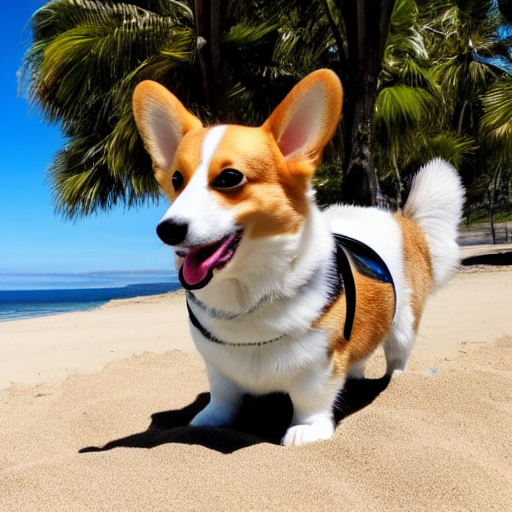

In [ ]:
from diffusers import EulerDiscreteScheduler

pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

generator = torch.Generator(device="cuda").manual_seed(seed)
img = pipe(prompt, generator=generator, num_inference_steps=50).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

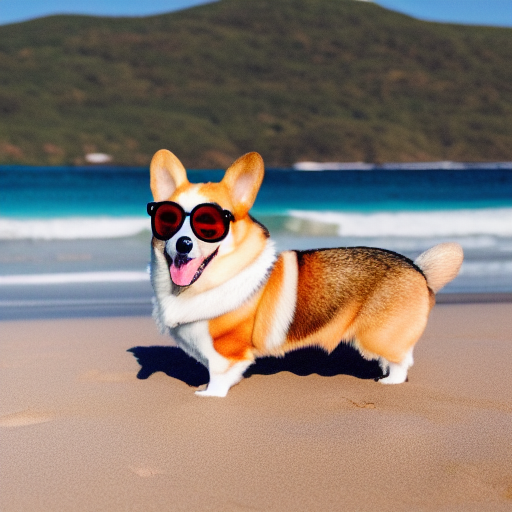

In [ ]:
from diffusers import EulerAncestralDiscreteScheduler

pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

generator = torch.Generator(device="cuda").manual_seed(seed)
img = pipe(prompt, generator=generator, num_inference_steps=50).images[0]
img